In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    return concat_df

In [6]:
yunrip_df = data_prep('연립다세대', '매매')
print(yunrip_df.shape)
yunrip_df.head()

16it [00:02,  6.71it/s]


(688279, 12)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 1264-3,개포로31길 23-7,(1264-3),53.28,29.23,11500,-1,1992.0,14.0,2006-08-29,215.840841,29.0
1,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
3,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
4,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0


In [7]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [10]:
inv_df = last_df[last_df['지번주소'].str.contains('영등포구 영등포동7가')]
print(inv_df.shape)
inv_df.head()

(1142, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
756385,서울특별시 영등포구 영등포동7가 1-1,대,178.2,준주거지역,지정되지않음,아파트,평지,사다리형,중로각지,사다리형
756386,서울특별시 영등포구 영등포동7가 1-10,대,56.2,준주거지역,지정되지않음,아파트,평지,사다리형,중로각지,사다리형
756387,서울특별시 영등포구 영등포동7가 1-14,대,26.4,준주거지역,지정되지않음,아파트,평지,사다리형,중로각지,사다리형
756388,서울특별시 영등포구 영등포동7가 1-15,대,7.3,준주거지역,지정되지않음,아파트,평지,사다리형,중로각지,사다리형
756389,서울특별시 영등포구 영등포동7가 1-4,대,12.2,준주거지역,지정되지않음,아파트,평지,사다리형,중로각지,사다리형


In [11]:
inv_df['토지이동상황'].value_counts()

아파트     494
상업용     141
도로등     103
주상나지     81
단독       75
주상용      61
주상기타     54
업무용      34
상업기타     33
주거기타     23
주거나지     16
상업나지     16
다세대       9
주차장등      1
공원등       1
Name: 토지이동상황, dtype: int64

In [12]:
dandok_df = inv_df[inv_df['토지이동상황'] == '단독']
print(dandok_df.shape)
dandok_df.head()

(75, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
756902,서울특별시 영등포구 영등포동7가 29-123,대,261.0,준주거지역,지정되지않음,단독,평지,자루형,세로한면(가),자루형
757051,서울특별시 영등포구 영등포동7가 63-17,대,31.7,준공업지역,지정되지않음,단독,평지,부정형,세로한면(가),부정형
757054,서울특별시 영등포구 영등포동7가 63-20,대,151.1,준공업지역,지정되지않음,단독,평지,부정형,세로한면(가),부정형
757060,서울특별시 영등포구 영등포동7가 63-27,대,2.6,준공업지역,지정되지않음,단독,평지,세로장방,세로한면(가),장방형
757061,서울특별시 영등포구 영등포동7가 63-29,대,86.3,준공업지역,지정되지않음,단독,평지,정방형,세로각지(가),정방형


In [13]:
dandok_df['용도지역명1'].value_counts(normalize=True)

준공업지역    0.813333
준주거지역    0.186667
Name: 용도지역명1, dtype: float64

In [14]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [15]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])
yunrip_merge_df['구'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_merge_df['동'] = yunrip_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [16]:
target_gu = '강동구'
target_dong = '고덕동'
target_purpose = '2종일반'

In [17]:
target_df = yunrip_merge_df[
    (yunrip_merge_df['구'] == target_gu)
    &(yunrip_merge_df['동'] == target_dong)
    &(yunrip_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_merge_df['건물연식'] <= 4)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(49, 23)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
672090,서울특별시 강동구 고덕동 292-5,동남로82길 29-12,고덕파크빌1,28.52,19.32,28500,3,2020.0,0.0,2020-10-06,999.298738,1.0,대,194.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,강동구,고덕동
672091,서울특별시 강동구 고덕동 292-5,동남로82길 29-12,고덕파크빌1,28.08,19.02,27650,2,2020.0,0.0,2020-10-06,984.686610,1.0,대,194.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,강동구,고덕동
672092,서울특별시 강동구 고덕동 292-5,동남로82길 29-12,고덕파크빌1,28.52,19.32,28100,2,2020.0,0.0,2020-10-06,985.273492,1.0,대,194.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,강동구,고덕동
672093,서울특별시 강동구 고덕동 292-5,동남로82길 29-12,고덕파크빌1,30.15,20.43,29150,6,2020.0,0.0,2020-10-06,966.832504,1.0,대,194.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,강동구,고덕동
672094,서울특별시 강동구 고덕동 292-5,동남로82길 29-12,고덕파크빌1,30.40,20.60,29400,6,2020.0,0.0,2020-10-06,967.105263,1.0,대,194.4,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),정방형,강동구,고덕동


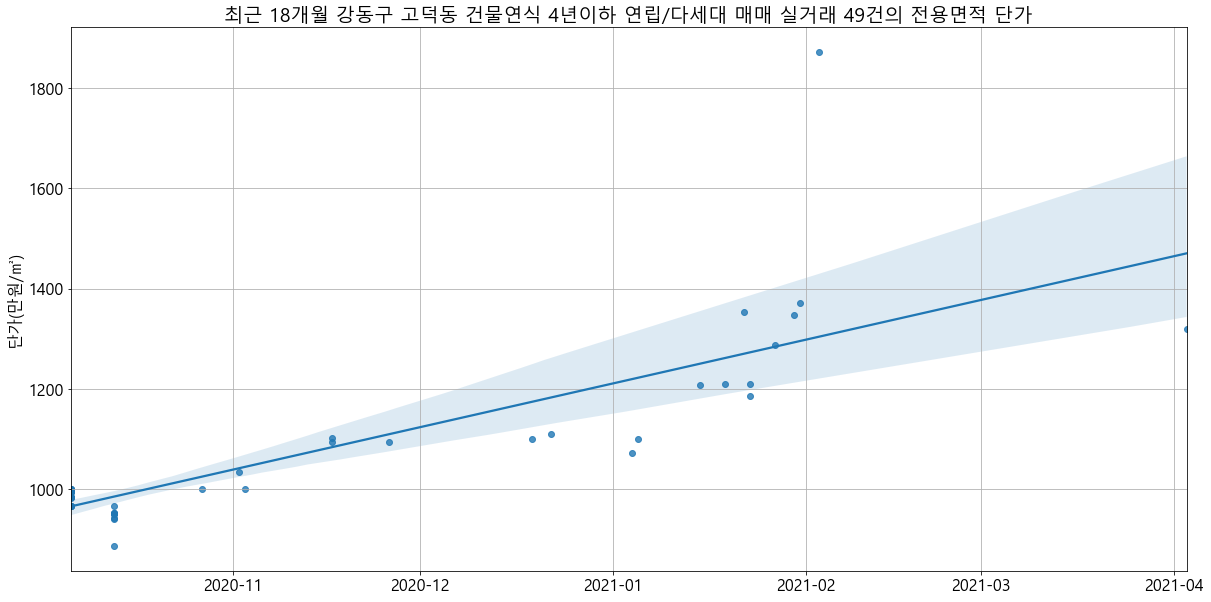

In [18]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 18개월 {} {} 건물연식 4년이하 연립/다세대 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/산포도.png'.format(target_gu, target_dong))

In [19]:
concat_df = pd.concat([target_df])

In [20]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [21]:
selected_df = concat_df[['지번주소', '건물명', '건축년도', '단가평균', '용도지역명1']].drop_duplicates()
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)
print(selected_df.shape)
selected_df.head()

(7, 5)


,지번주소,건물명,건축년도,단가평균,용도지역명1
0,서울특별시 강동구 고덕동 153-4,지월드고덕,2020.0,1273.103419,제2종일반주거지역
1,서울특별시 강동구 고덕동 162-0,누리안 파크리움,2019.0,1076.143733,제2종일반주거지역
2,서울특별시 강동구 고덕동 167-0,에버빌,2020.0,944.079767,제2종일반주거지역
3,서울특별시 강동구 고덕동 183-1,(183-1),2019.0,1284.547489,제2종일반주거지역
4,서울특별시 강동구 고덕동 188-7,정나재,2021.0,1320.220653,제2종일반주거지역


In [22]:
selected_df

,지번주소,건물명,건축년도,단가평균,용도지역명1
0,서울특별시 강동구 고덕동 153-4,지월드고덕,2020.0,1273.103419,제2종일반주거지역
1,서울특별시 강동구 고덕동 162-0,누리안 파크리움,2019.0,1076.143733,제2종일반주거지역
2,서울특별시 강동구 고덕동 167-0,에버빌,2020.0,944.079767,제2종일반주거지역
3,서울특별시 강동구 고덕동 183-1,(183-1),2019.0,1284.547489,제2종일반주거지역
4,서울특별시 강동구 고덕동 188-7,정나재,2021.0,1320.220653,제2종일반주거지역
5,서울특별시 강동구 고덕동 292-5,고덕파크빌1,2020.0,989.858895,제2종일반주거지역
6,서울특별시 강동구 고덕동 292-6,고덕파크빌2,2020.0,988.377642,제2종일반주거지역


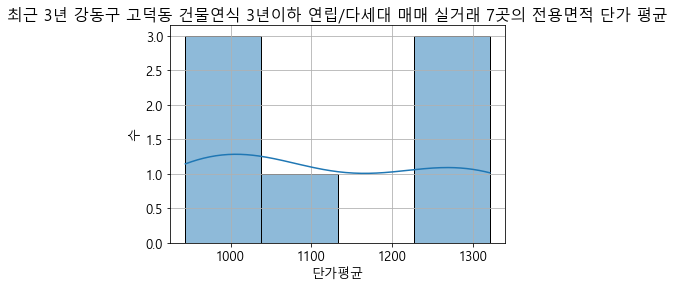

<Figure size 432x288 with 0 Axes>

In [23]:
font = {'size': 13}
matplotlib.rc('font', **font)
plt.grid(True)
plt.ylabel('수')
plt.title('최근 3년 {} {} 건물연식 3년이하 연립/다세대 매매 실거래 {}곳의 전용면적 단가 평균'.format(target_gu, target_dong, selected_df.shape[0]))
sns.histplot(selected_df['단가평균'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/분포도.png'.format(target_gu, target_dong))
plt.show()
plt.clf()

In [24]:
selected_df = selected_df.sort_values(['지번주소']).reset_index(drop=True)

In [25]:
selected_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/실거래가.xlsx'.format(target_gu, target_dong), index=False)